In [1]:
import math
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

# Seeding
np.random.seed(42)


<a id='intro'></a>

# (Example based learning) Introduction to the bias-variance tradeoff

---

The aim of this lecture is to visually explore the concept of bias and variance in modeling and the tradeoff between the two.

Below we will be fitting models predicting student morale from the day number in the course. We have the "true function" representing the function from which any student in the population of all students measurements are generated (plus some noise due to individual variability or measurement error). 

**The goal when building a model is to minimize the bias _and_ the variance.** The perfect model would have zero bias and zero variance. In reality, the bias or the variance (typically) increases while the other decreases.



<a id='set-up-data'></a>

## Set up the "student morale" data

---

### The True Morale Function

We will be creating two variables:
- $\mathcal{X}$ - Days elapsed in the course.
- $\mathcal{Y}$ - Morale measured at a given day.
- $f$ - The `interp1d` function creates an interpolation function for us between the week numbers and morale points. The `kind='cubic'` parameter indicates the smoothing of the interpolation. Below are the day numbers in the course and the morale function, which takes a day as an argument and returns a morale number.



In [2]:
# X: our population is days here.
days = np.arange(1, 85, 1)

# We use weekpoints and moralepoints to generate our true function. Note that one should not be confused as to why we are subsetting data from population here and call it the true function. This is just a convenient way to generate the true function.
weekpoints = [1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]
moralepoints = [20, 30, 35, 18, 6, 3, 12, 35, 44, 53, 62, 73, 80]

# f: Construct the true function f
morale_func = interp1d(weekpoints, moralepoints, kind="cubic")

# Y: our corresponding Y
morale_true = morale_func(days)

# For convenience, we rename our variables
X_true = days[:]
Y_true = morale_true[:]
f_true = morale_func

---

### True Function Plot

We can plot out the "true function" of days predicting morale below:

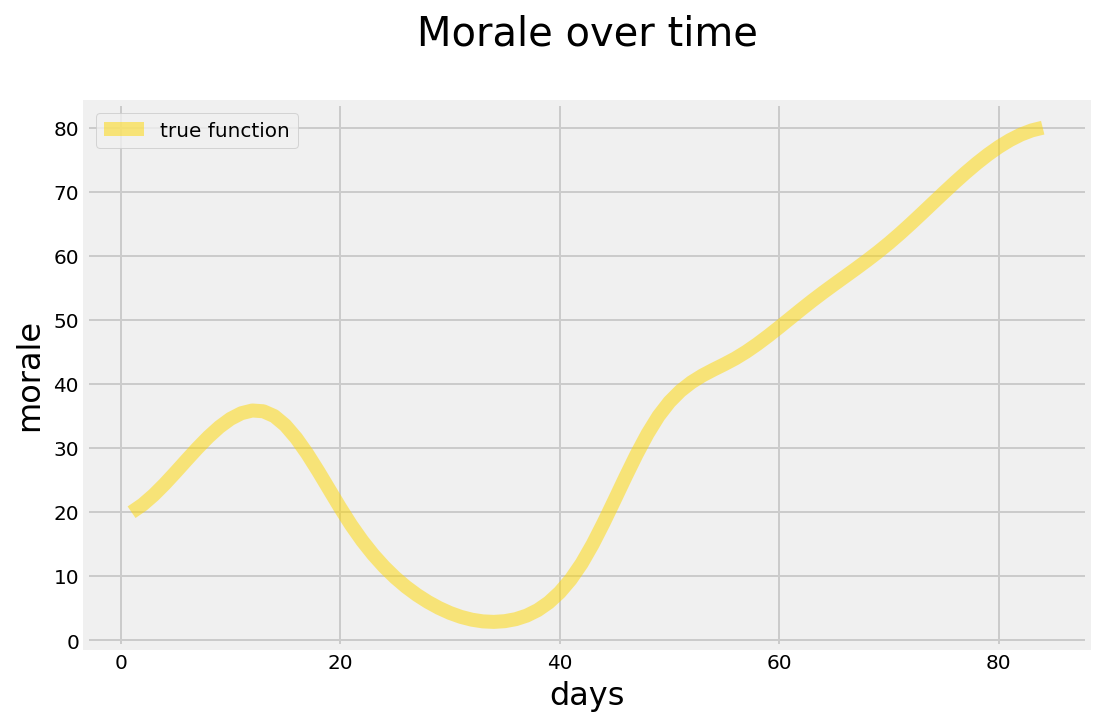

In [3]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

ax.plot(X_true, Y_true, lw=7.0, c="gold", alpha=0.5, label="true function")

ax.set_xlabel("days", fontsize=16)
ax.set_ylabel("morale", fontsize=16)
ax.set_title("Morale over time\n", fontsize=20)

plt.legend(loc="upper left")

plt.show()

We can interpret this "true function" in different ways:

> **1. As morale without individual variance:** the true function is the baseline morale for each time point that all students vary around to some degree. Students' morale at any given time point is this baseline morale plus or minus some individual deviation. 

When coding this in python, for each "student" we take the *true* measure of morale from the morale function, and then to create the individual variance we will add random noise to that starting point. 

> **2. As morale without measurement error:** maybe all student morale at every timepoint is the same, it's just that our way of measuring morale is unreliable. The true function represents the morale at any timepoint for any student without measurement error.

If our measurement tool was perfect (a perfect morale survey) we would measure the same morale for every student at each time point. But if the survey form is broken and randomly changes answers by students, for example, then we are adding noise to the measured morale for each observation. 

> **3. As an average morale across infinite students:** our measurements of morale vary at each time point for each student, but if we had an infinite number of students and averaged all of their morale measurements across all time points, we would end up with the true function of `morale(time)`. 

**In each case, we are describing morale as a function of time without error, where each is describing a different source of error:**
1. Error resulting from an imperfect relationship between time and morale.
2. Error resulting from an imperfect ability to measure morale.
3. Error resulting from an insufficient amount of data to quantify the relationship correctly.

We will see that each of these sources of error combined make up the full error in any model we build. Respectively:
1. The **bias**.
2. The **irreducible error**.
3. The **variance**. To understand the above example, as you have more data, you are more and more confident your model $h$ will converge to the true function and hence reduce variance, and run less risk of overfitting.

You will always have error in your models, it just depends how much and what proportion of each type. We will formalize these components of error in a model further down.

<a id='generate-students'></a>
## Generate a sample of students

---

Say we have four students: student A, B, C, and D.

Each student has had their morale checked 12 different times throughout the course, but not necessarily at the same times.

**Below is a function that will generate the days and morale for each student as a dictionary object.**

> *Note: here we are using the morale function to get the true morale for a given day, then adding the individual variance and/or measurement error from a normal distribution.*

We will be creating two variables:
- $\mathrm{X}$ - The sample drawn from $\mathcal{X}$ Days elapsed in the course.
- $\mathrm{Y}$ - The Morale measured with correspondence to each sample $\mathrm{x}^{(i)} \in \mathrm{X}$.
- $f$ - The `interp1d` function creates an interpolation function for us between the week numbers and morale points. The `kind='cubic'` parameter indicates the smoothing of the interpolation. Below are the day numbers in the course and the morale function, which takes a day as an argument and returns a morale number.



In [4]:
def make_students(f_true, X_true: np.ndarray, num_samples: int = 12) -> Dict:
    """Sample data from $\mathcal{X}$

    students is a dictionary containing 4 students as keys, and in each student, we have their day and corresponding morale.

    Args:
        f_true ([type]): [description]
        X_true (np.ndarray): [description]
        num_samples (int, optional): [description]. Defaults to 12.

    Returns:
        Dict[dict]: [description]
    """
    students = {}
    mu, sigma = 0, 13
    for student in ["A", "B", "C", "D"]:
        x_sampled = np.random.choice(X_true, replace=False, size=num_samples)
        y_sampled = f_true(x_sampled) + np.random.normal(mu, sigma, size=num_samples)
        students[student] = {"X_sampled": x_sampled, "Y_sampled": y_sampled}
    return students

In [5]:
students = make_students(f_true, X_true, num_samples=12)

Take careful note here that each students' data here are the **true** values,with a small error which follows a normal distribution added to it. Our aim is to later compare how the predictions compare to our true values.

<a id='student-a'></a>

### Student A's morale over time

---

Below we can plot student A's morale at each day. The true function is also plotted in yellow.

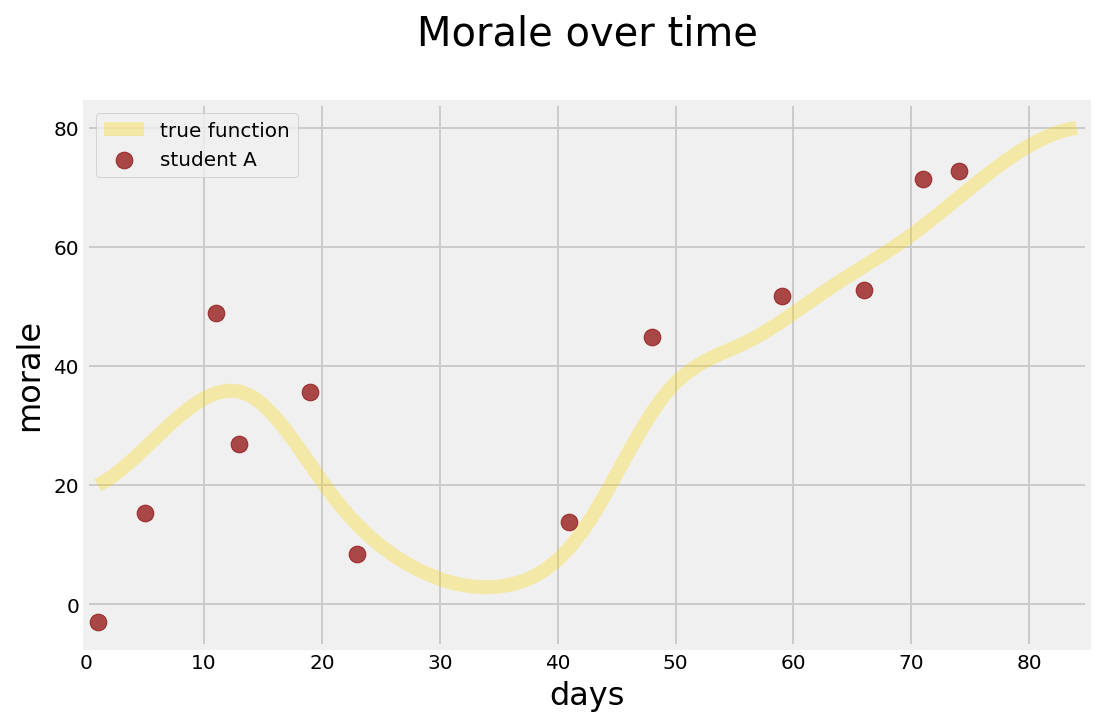

In [6]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

ax.plot(days, morale_true, lw=7.0, c="gold", alpha=0.3, label="true function")
ax.scatter(
    students["A"]["X_sampled"],
    students["A"]["Y_sampled"],
    s=70,
    c="darkred",
    label="student A",
    alpha=0.7,
)

ax.set_xlabel("days", fontsize=16)
ax.set_ylabel("morale", fontsize=16)
ax.set_title("Morale over time\n", fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc="upper left")

plt.show()

<a id='a-model'></a>

## Build a model for days predicting morale using student A's data

---

With this student's data, I decide to model the relationship between days and morale with a linear regression.

My model is:

### $$\hat{morale} = \beta_0 + \beta_1days$$

**Construct the model:**

In [7]:
student_A_X_sampled = students["A"]["X_sampled"]
student_A_Y_sampled = students["A"]["Y_sampled"]

model_A = LinearRegression()
model_A.fit(student_A_X_sampled[:, np.newaxis], student_A_Y_sampled)
# model_A_Y_predictions = model_A.predict(days[:, np.newaxis])
model_A_Y_predictions = model_A.predict(student_A_X_sampled[:, np.newaxis])

**Plot the modeled relationship between days and morale:**

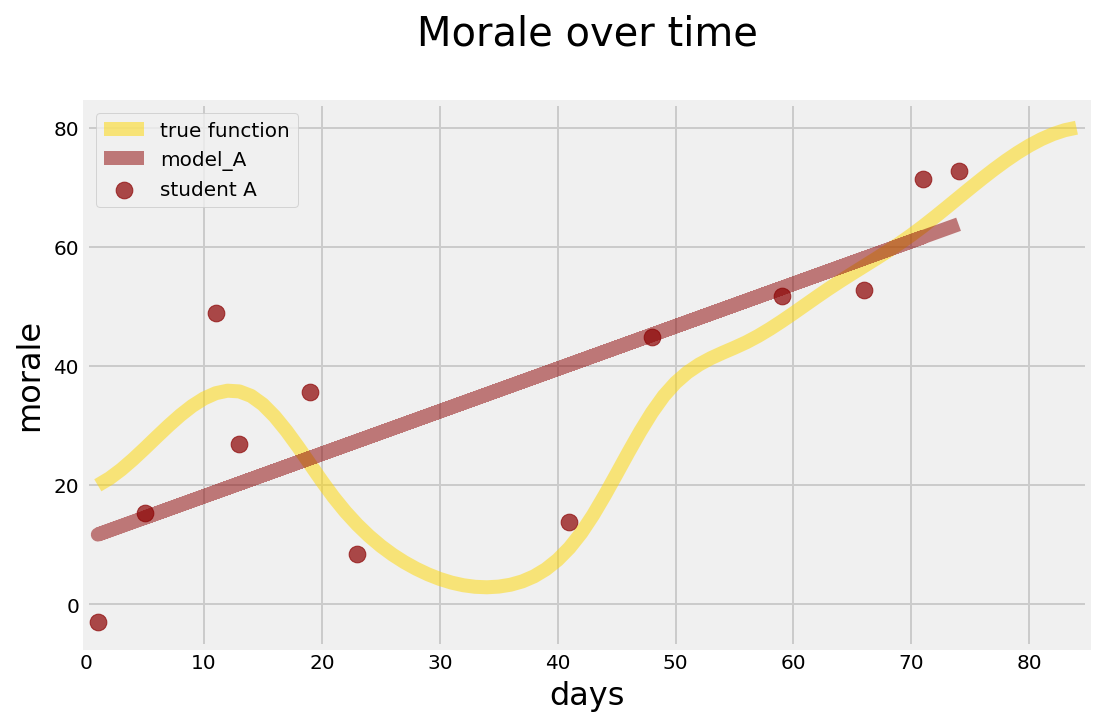

In [8]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

ax.plot(X_true, Y_true, lw=7.0, c="gold", alpha=0.5, label="true function")
ax.plot(student_A_X_sampled, model_A_Y_predictions, lw=7.0, c="darkred", alpha=0.5, label="model_A")

# Uncomment to see the full line if we were to predict on the population X_true
# ax.plot(X_true, model_A.predict(X_true[:, np.newaxis]), lw=7., c='blue', alpha=0.5, label='model_A predictions on true population')

ax.scatter(
    students["A"]["X_sampled"],
    students["A"]["Y_sampled"],
    s=70,
    c="darkred",
    label="student A",
    alpha=0.7,
)

ax.set_xlabel("days", fontsize=16)
ax.set_ylabel("morale", fontsize=16)
ax.set_title("Morale over time\n", fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc="upper left")

plt.show()

<a id='total-error'></a>

## The total error of a model

---

As you can see above, our regression line is an imperfect representation of the true function. Furthermore, the regression model fails to perfectly capture the variance of the morale in our sample data. 

The model is our blueprint for the estimation of morale. We have chosen to estimate morale from simply the number of days that have elapsed in the course. In doing so, we have made an assumption: morale is a linear function of days. 

**When we talk about the bias-variance tradeoff in modeling, and the bias and variance components of error, it is important to think about this in the context of building our model on many samples of the data.** For example, we take our model parameterization `morale ~ days` and build this on the data for student A, then student B, then student C, then student D, and so on. Think of the "students" as random samples of morale and days elapsed from the overall population.

**There are three sources of error in a model:**

### $$\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

### $$E\Big[\big(\hat{f}(x) - f(x)\big)^2\Big] = \big(\;\text{E}[\;\hat{f}(x)\;] - f(x)\;\big)^2 + \text{E}\big[\;(\;\hat{f}(x) - \text{E}[\;\hat{f}(x)\;])^2\;\big] + E\Big[\big(y - f(x)\big)^2\Big] $$

**Where**:

- $f(x)$ is the true function of y given the predictors.
- $\hat{f}(x)$ is the estimate of y with the model fit on a random sample of the predictors.
- $E\Big[\big(\hat{f}(x) - f(x)\big)^2\Big]$ is the average squared error across multiple models fit on different  random samples between the model and the true function.
- $\text{E}[\;\hat{f}(x)\;]$ is the average of estimates for given predictors across multiple models fit on different random samples.
- $E\Big[\big(y - f(x)\big)^2\Big]$ is the average squared error between the true values and the predictions from the true function of the predictors. This is the **irreducible error**.
- $\big(\;\text{E}[\;\hat{f}(x)\;] - f(x)\;\big)^2$ is the squared error between the average predictions across multiple models fit on different random samples and the prediction of the true function. This is the **bias** (squared).
- $\text{E}\big[\;(\;\hat{f}(x) - \text{E}[\;\hat{f}(x)\;])^2\;\big]$ is the average squared distance between individual model predictions and the average prediction of models across multiple random samples. This is the **variance**.

**The irreducible error is "noise" – error in the measurement of our target that cannot be accounted for by our predictors.**
- The true function represents the most perfect relationship between predictors and target, but that does not mean that our variables can perfectly predict the target.
- The irreducible error can be thought of as the measurement error: variation in the target that we cannot represent.

We will go into the bias and variance components individually, in more detail.

<a id='bias'></a>

## Bias

---

The $bias^2$ is the source of error in our model that represents how *oversimplified* our model is. In our example, we have built a function to predict the morale of students as a linear function of days elapsed. However, we can see from the true function that the relationship between days and morale is not a line. This error is encapsulated in the bias.


### $$Bias^2 = \big(\;\text{E}[\;\hat{f}(x)\;] - f(x)\;\big)^2$$


> **Remember:** we have to think about measuring the bias and variance using different fits of our model across multiple random samples! The bias represents the deviation of the *average predictions across models* from the true function.

**What does having a high vs. low bias mean?**
- If our models are consistently wrong, then the bias will be large.
- Alternatively, if our models are consistently correct then the bias will be small.
- Bias will be small if the errors across our models built on random samples and tested using the same predictors are incorrect in different directions that average out close to 0. 

Linear methods like regression tend to have a high bias because we construct a simplification of the true function.

**Below we can plot the error differences between the true function and our model built on student A's data.** 
>  No matter how many lines we fit on different students, those regression lines are never going to average together into the nonlinear true function! Our average estimate across models will always deviate from the true function somewhere across the days.

### Coding the Bias function

### Plot difference from True Function

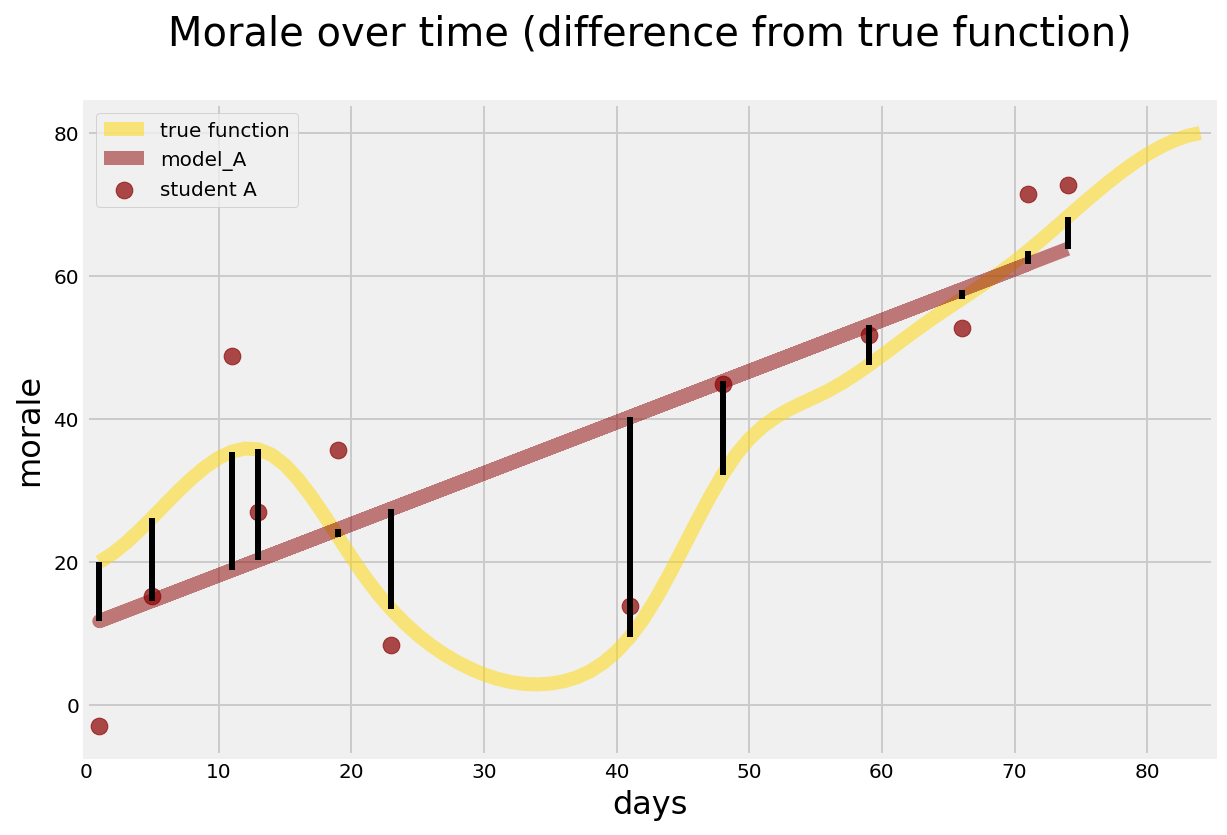

In [9]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()

ax.plot(X_true, Y_true, lw=7.0, c="gold", alpha=0.5, label="true function")
ax.plot(student_A_X_sampled, model_A_Y_predictions, lw=7.0, c="darkred", alpha=0.5, label="model_A")

# Uncomment to see the full line if we were to predict on the population X_true
# ax.plot(X_true, model_A.predict(X_true[:, np.newaxis]), lw=7., c='blue', alpha=0.5, label='model_A predictions on true population')

ax.scatter(
    students["A"]["X_sampled"],
    students["A"]["Y_sampled"],
    s=70,
    c="darkred",
    label="student A",
    alpha=0.7,
)

np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
for day in students["A"]["X_sampled"]:
    # this is to reshape it to 2d array for prediction
    _day = np.array([[day]]).astype(int)
    _morale = model_A.predict(_day)
    ax.plot([day, day], [_morale, f_true(day)], c="black", lw=3.0)

ax.set_xlabel("days", fontsize=16)
ax.set_ylabel("morale", fontsize=16)
ax.set_title("Morale over time (difference from true function)\n", fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc="upper left")

plt.show()


<a id='variance'></a>
## Variance

---

The second component of error in the model is the variance of our predictions. 

Variance describes the extent to which the individual predictions from models built on different samples (students) deviate from the mean of all the model predictions.

### $$\text{Variance} = \text{E}\big[\;(\;\hat{f}(x) - \text{E}[\;\hat{f}(x)\;])^2\;\big]$$

**What does having a high vs. low variance mean?**
- The variance will be large if, for the same observation, models built on different random samples of the data will produce very different predictions.
- Variance is a measure of how *consistent* our model's predictions will be if it were fit on another sample of data. 
- Variance is low if the data we train the model on has very little effect on the predictions.

Note that variance is not a measure of how correct or incorrect the predictions are. It is a measure of how variable they are!

---

### Measuring more students

To better visualise the concept of model variance, lets say we measure a second student, student "B":

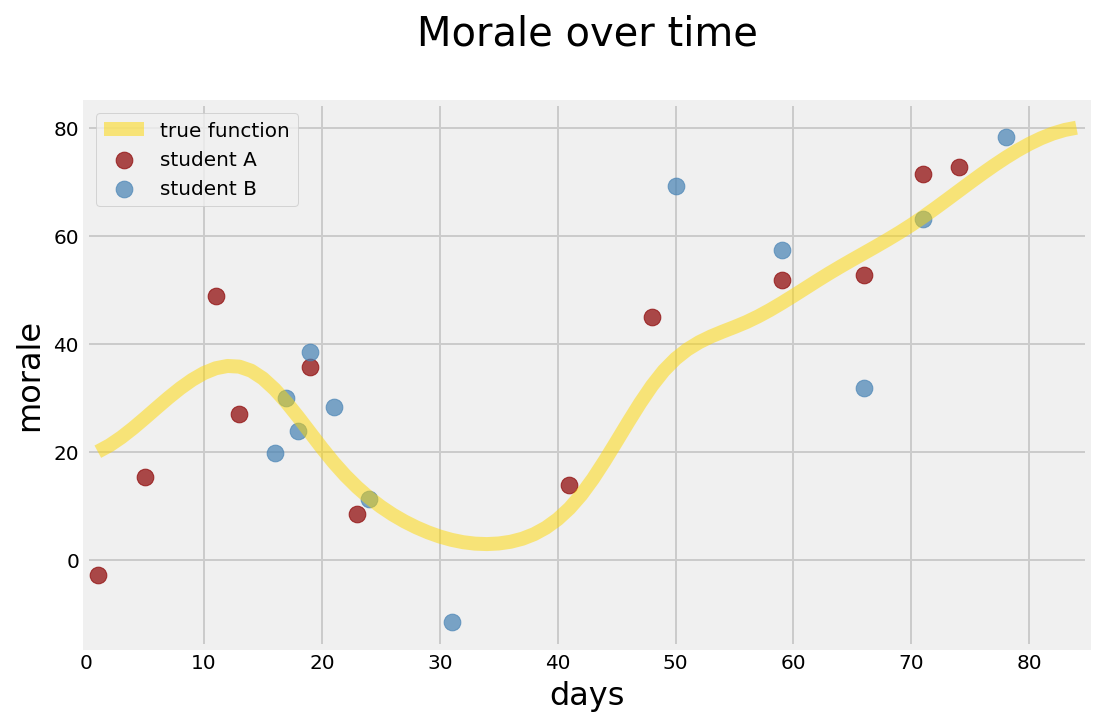

In [10]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()

ax.plot(X_true, Y_true, lw=7., c='gold', alpha=0.5, label='true function')

ax.scatter(students['A']['X_sampled'], students['A']['Y_sampled'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.scatter(students['B']['X_sampled'], students['B']['Y_sampled'],
           s=70, c='steelblue', label='student B', alpha=0.7)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

**Now we fit a new model to student B's data:**

In [11]:
# Fit student B's model

student_B_X_sampled = students["B"]["X_sampled"]
student_B_Y_sampled = students["B"]["Y_sampled"]

model_B = LinearRegression()
model_B.fit(student_B_X_sampled[:, np.newaxis], student_B_Y_sampled)
# model_B_Y_predictions = model_B.predict(days[:, np.newaxis])
model_B_Y_predictions = model_B.predict(student_B_X_sampled[:, np.newaxis])

**What is the difference between the predictions of morale at the same time points between the model for student A and the model for student B?**

In [12]:
# fig = plt.figure(figsize=(8,5))
# ax = fig.gca()

# ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

# Apred = Amod.predict(days[:, np.newaxis])
# ax.plot(days, Apred, lw=7., c='darkred', alpha=0.5, label='A model')

# Bpred = Bmod.predict(days[:, np.newaxis])
# ax.plot(days, Bpred, lw=7., c='steelblue', alpha=0.5, label='B model')

# ax.scatter(students['A']['days'], students['A']['morale'],
#            s=70, c='darkred', label='student A', alpha=0.7)

# ax.scatter(students['B']['days'], students['B']['morale'],
#            s=70, c='steelblue', label='student B', alpha=0.7)

# ax.fill_between(days, Apred, Bpred, color='grey', hatch='//', edgecolor=None)

# ax.set_xlabel('days', fontsize=16)
# ax.set_ylabel('morale', fontsize=16)
# ax.set_title('Morale over time (difference between estimates)\n', fontsize=20)
# ax.set_xlim([0, 85])

# plt.legend(loc='upper left')

# plt.show()

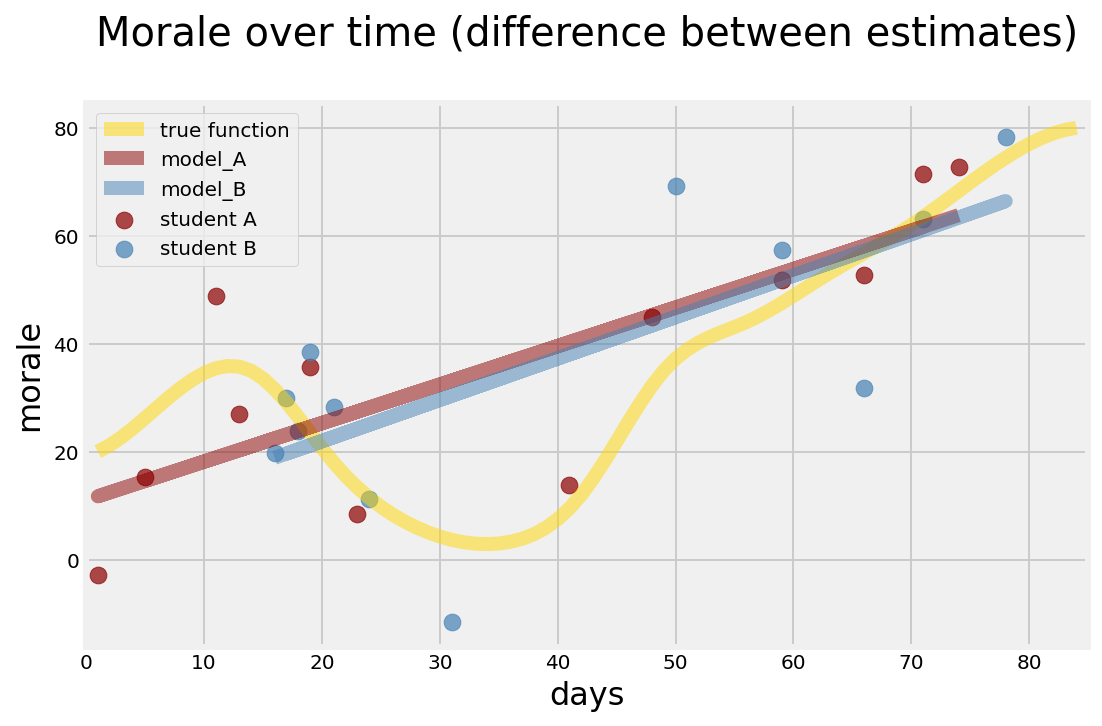

In [13]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

ax.plot(X_true, Y_true, lw=7.0, c="gold", alpha=0.5, label="true function")
ax.plot(student_A_X_sampled, model_A_Y_predictions, lw=7.0, c="darkred", alpha=0.5, label="model_A")
ax.plot(
    student_B_X_sampled, model_B_Y_predictions, lw=7.0, c="steelblue", alpha=0.5, label="model_B"
)

# Uncomment to see the full line if we were to predict on the population X_true
# ax.plot(X_true, model_A.predict(X_true[:, np.newaxis]), lw=7., c='blue', alpha=0.5, label='model_A predictions on true population')
# ax.plot(X_true, model_B.predict(X_true[:, np.newaxis]), lw=7., c='blue', alpha=0.5, label='model_B predictions on true population')

ax.scatter(
    students["A"]["X_sampled"],
    students["A"]["Y_sampled"],
    s=70,
    c="darkred",
    label="student A",
    alpha=0.7,
)
ax.scatter(
    students["B"]["X_sampled"],
    students["B"]["Y_sampled"],
    s=70,
    c="steelblue",
    label="student B",
    alpha=0.7,
)

# Technically we can only use this line if we were to predict on the X_true -
# ax.fill_between(student_A_X_sampled, model_A_Y_predictions, model_B_Y_predictions, color='grey', hatch='//', edgecolor=None)

ax.set_xlabel("days", fontsize=16)
ax.set_ylabel("morale", fontsize=16)
ax.set_title("Morale over time (difference between estimates)\n", fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc="upper left")

plt.show()

<a id='3-students'></a>
## Bias and variance using 3 models

---

Below we will assess the morale of 3 different students over the days in the course at different times. 

We can build these simple `morale ~ time` models for each and plot the regression lines.

These models are **high bias and low variance**. This is because there is a considerable amount of difference between the average of the model predictions and the true function, but not a lot of variation in predictions at time points across our models for the 3 students.

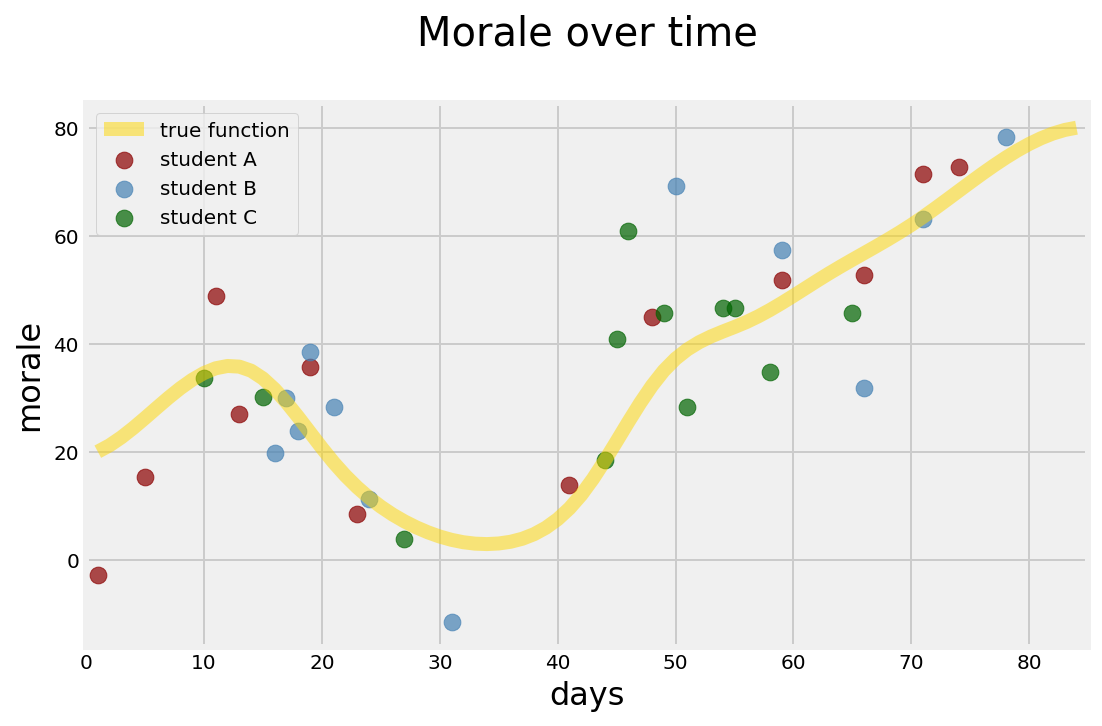

In [14]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

ax.plot(X_true, Y_true, lw=7.0, c="gold", alpha=0.5, label="true function")

ax.scatter(
    students["A"]["X_sampled"],
    students["A"]["Y_sampled"],
    s=70,
    c="darkred",
    label="student A",
    alpha=0.7,
)

ax.scatter(
    students["B"]["X_sampled"],
    students["B"]["Y_sampled"],
    s=70,
    c="steelblue",
    label="student B",
    alpha=0.7,
)

ax.scatter(
    students["C"]["X_sampled"],
    students["C"]["Y_sampled"],
    s=70,
    c="darkgreen",
    label="student C",
    alpha=0.7,
)

ax.set_xlabel("days", fontsize=16)
ax.set_ylabel("morale", fontsize=16)
ax.set_title("Morale over time\n", fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc="upper left")

plt.show()

In [15]:
# Fit student C's model

student_C_X_sampled = students["C"]["X_sampled"]
student_C_Y_sampled = students["C"]["Y_sampled"]

model_C = LinearRegression()
model_C.fit(student_C_X_sampled[:, np.newaxis], student_C_Y_sampled)
# model_C_Y_predictions = model_C.predict(days[:, np.newaxis])
model_C_Y_predictions = model_C.predict(student_C_X_sampled[:, np.newaxis])

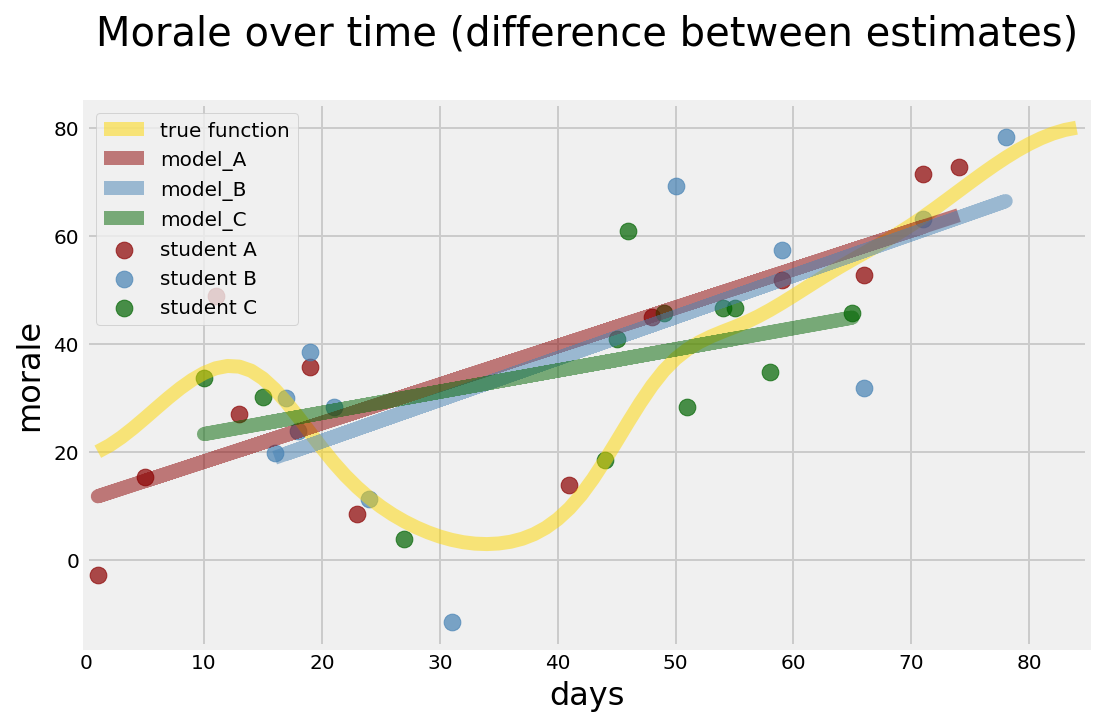

In [16]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

ax.plot(X_true, Y_true, lw=7.0, c="gold", alpha=0.5, label="true function")
ax.plot(student_A_X_sampled, model_A_Y_predictions, lw=7.0, c="darkred", alpha=0.5, label="model_A")
ax.plot(
    student_B_X_sampled, model_B_Y_predictions, lw=7.0, c="steelblue", alpha=0.5, label="model_B"
)
ax.plot(
    student_C_X_sampled, model_C_Y_predictions, lw=7.0, c="darkgreen", alpha=0.5, label="model_C"
)
# Uncomment to see the full line if we were to predict on the population X_true
# ax.plot(X_true, model_A.predict(X_true[:, np.newaxis]), lw=7., c='blue', alpha=0.5, label='model_A predictions on true population')
# ax.plot(X_true, model_B.predict(X_true[:, np.newaxis]), lw=7., c='blue', alpha=0.5, label='model_B predictions on true population')

ax.scatter(
    students["A"]["X_sampled"],
    students["A"]["Y_sampled"],
    s=70,
    c="darkred",
    label="student A",
    alpha=0.7,
)
ax.scatter(
    students["B"]["X_sampled"],
    students["B"]["Y_sampled"],
    s=70,
    c="steelblue",
    label="student B",
    alpha=0.7,
)
ax.scatter(
    students["C"]["X_sampled"],
    students["C"]["Y_sampled"],
    s=70,
    c="darkgreen",
    label="student C",
    alpha=0.7,
)
# Technically we can only use this line if we were to predict on the X_true -
# ax.fill_between(student_A_X_sampled, model_A_Y_predictions, model_B_Y_predictions, color='grey', hatch='//', edgecolor=None)

ax.set_xlabel("days", fontsize=16)
ax.set_ylabel("morale", fontsize=16)
ax.set_title("Morale over time (difference between estimates)\n", fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc="upper left")

plt.show()


### Coding the Variance Function

The version I code out here follows "closely" to the quote from ISLR:
>  **Variance** refers to the amount by which our $g$ would change if we estimated it using a different training dataset.

However, the more correct definition is to have a fixed test set $\mathcal{D}_{test}$, and different hypothesis models $h_{i}$, fitted on different sampled dataset $\mathcal{D}_{i}$, and calculate the expected error. For the detailed implementation refer to `mlextend`, or I have copied his code in the Conceptual Definition section.

In [17]:
def fixed_model_variance(
    fixed_model,
    f_true,
    X_true: np.ndarray,
    y_true: np.ndarray,
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_val: np.ndarray = None,
    Y_val: np.ndarray = None,
    num_iterations: int = 50,
    num_samples: int = 12,
    replace: bool = True,
) -> float:

    # fit the model on the ORIGINAL training data and this our fixed g initiated with fixed parameters weights.
    fixed_model.fit(X_train, Y_train)

    # predict on X_val/X_test
    y_pred = fixed_model.predict(X_val)
    print("y pred on X_val", y_pred)
    # mean predictions of a single model over various samples
    tmp_pred: List = []

    for _ in range(1, num_iterations + 1):

        # sample data from population
        assert (
            num_samples == X_train.shape[0]
        ), "sampled data must be same length as the num of samples in X_train"
        x_sampled = np.random.choice(X_true.flatten(), replace=replace, size=num_samples)

        # find corresponding y_sampled from the sampled x data
        y_sampled = f_true(x_sampled)

        # reshape to fit into LR
        x_sampled = x_sampled.reshape(-1, 1)
        y_sampled = y_sampled.reshape(-1, 1)

        # fit on the sampled data : WRONG, do not fit again and again.
        # _ = model.fit(x_sampled, y_sampled)

        # IMPT: predicting using LR model on THE SAME X_sample where X_sample is the original training set. The only difference is everytime we fit on the newly sampled X and Y in the loop,
        # WRONG: we are getting different parameters coefficients beta | Correct: ? we are not getting new parameters!
        y_pred_on_sample_i = fixed_model.predict(x_sampled)

        # append to our list
        tmp_pred.append(y_pred_on_sample_i)

    # as an example if tmp_pred = [[1,2,3], [2,4,6]] which holds 2 sets of predictions using 2 different samples
    # then mean_pred = ([1,2,3] + [2,4,6]) / 2 = [1.5, 3, 4.5]
    print(tmp_pred)
    mean_pred = np.mean(tmp_pred, axis=0)
    print("mean pred over different x_sampled", mean_pred)
    # you can use raw for loops if you really want to understand the derivation.
    _variance = np.sum(np.square(y_pred - mean_pred))
    print(_variance)
    # divide by the number of times you re-sampled times the number of sample. That is because variance is averaged over all samples in question, which is why num_iter * num_samples
    _variance = _variance / (num_iterations * num_samples)

    # TODO: Up till here we calculated $\;(\;g(x) - \text{E}[\;g(x)\;])^2$, if we want the "E" in front, we need to refactor our code to loop over multiple models as well. So this actually means that in line 37, where I said wrong, we need to
    # put another for loop to loop through "different hypothesis h_{i} with different parameters each time!"

    return _variance

In [18]:
def varied_model_variance(
    model,
    f_true,
    X_true: np.ndarray,
    y_true: np.ndarray,
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_val: np.ndarray = None,
    Y_val: np.ndarray = None,
    num_iterations: int = 50,
    num_samples: int = 12,
    replace: bool = True,
) -> float:

    # fit the model on the ORIGINAL training data and this our fixed g initiated with fixed parameters weights.
    model.fit(X_train, Y_train)

    # predict on X_val/X_test
    y_pred = model.predict(X_val)
    print("y pred on X_val", y_pred)
    # mean predictions of a single model over various samples
    tmp_pred: List = []

    for _ in range(1, num_iterations + 1):

        # sample data from population
        assert (
            num_samples == X_train.shape[0]
        ), "sampled data must be same length as the num of samples in X_train"
        x_sampled = np.random.choice(X_true.flatten(), replace=replace, size=num_samples)

        # find corresponding y_sampled from the sampled x data
        y_sampled = f_true(x_sampled)

        # reshape to fit into LR
        x_sampled = x_sampled.reshape(-1, 1)
        y_sampled = y_sampled.reshape(-1, 1)

        # fit on the sampled data : WRONG, do not fit again and again.
        _ = model.fit(x_sampled, y_sampled)

        # IMPT: predicting using LR model on THE SAME X_sample where X_sample is the original training set. The only difference is everytime we fit on the newly sampled X and Y in the loop,
        # WRONG: we are getting different parameters coefficients beta | Correct: ? we are not getting new parameters!
        y_pred_on_sample_i = model.predict(X_val)

        # append to our list
        tmp_pred.append(y_pred_on_sample_i)

    # as an example if tmp_pred = [[1,2,3], [2,4,6]] which holds 2 sets of predictions using 2 different samples
    # then mean_pred = ([1,2,3] + [2,4,6]) / 2 = [1.5, 3, 4.5]
    
    tmp_pred = np.concatenate(tmp_pred, axis=None).reshape(num_iterations, -1)
    print(tmp_pred)
    mean_pred = np.mean(tmp_pred, axis=0)
    print("mean pred over different x_sampled", mean_pred)
    # you can use raw for loops if you really want to understand the derivation.
    _variance = np.sum(np.square(tmp_pred - mean_pred))
    print(_variance)
    # divide by the number of times you re-sampled times the number of sample. That is because variance is averaged over all samples in question, which is why num_iter * num_samples
    _variance = _variance / (num_iterations * num_samples)

    # TODO: Up till here we calculated $\;(\;g(x) - \text{E}[\;g(x)\;])^2$, if we want the "E" in front, we need to refactor our code to loop over multiple models as well. So this actually means that in line 37, where I said wrong, we need to
    # put another for loop to loop through "different hypothesis h_{i} with different parameters each time!"

    return _variance

In [19]:
X_true_ = X_true.reshape(-1, 1)
Y_true_ = Y_true
X_train = student_C_X_sampled.reshape(-1, 1)
Y_train = student_C_Y_sampled
num_iterations = 3
num_samples = 12
fixed_model = LinearRegression()

# fixed_model_variance(fixed_model,f_true, X_true_, Y_true_, X_train,Y_train, X_train,Y_train, num_iterations=num_iterations, num_samples=num_samples)

varied_model_variance(fixed_model,f_true, X_true_, Y_true_, X_train,Y_train, X_train,Y_train, num_iterations=num_iterations, num_samples=num_samples)

y pred on X_val [29.93129721 44.83981841 42.09351187 39.34720534 23.26169562 40.52419385
 40.91652336 38.56254633 36.6008988  36.99322831 25.22334315 37.38555781]
[[29.72011879 44.16868016 41.50710307 38.84552597 23.25628871 39.98620187
  40.36642717 38.08507537 36.18394888 36.56417418 25.1574152  36.94439948]
 [19.25663305 56.13278619 49.33981062 42.54683504  2.75940665 45.45811028
  46.42853537 40.60598487 35.75385946 36.72428454  7.61153206 37.69470962]
 [22.85408156 51.77003124 46.44340893 41.11678662  9.91799881 43.39962476
  44.1605708  39.59489453 35.79016431 36.55111036 13.72272903 37.3120564 ]]
mean pred over different x_sampled [23.94361113 50.6904992  45.76344087 40.83638254 11.97789805 42.94797897
 43.65184445 39.42865159 35.90932422 36.61318969 15.49722543 37.31705517]
580.9284821261324


16.136902281281454

<a id='increasing-complexity'></a>

## Increasing complexity to try and capture the true function

---

Currently our models predict that morale simply increases over time. 

Looking at the true function, we can see that there is an increase, then a decrease, and then an increase again. 

Just modeling with a linear effect of time alone can't fit a curve; there is only one coefficient being multiplied by time to make our morale prediction. We could, however, add more variables created from time such as $time^2$, $time^3$, etc.

### $$\hat{morale} = \beta_0 + \beta_1 t + \beta_2 t^2$$
### $$\hat{morale} = \beta_0 + \beta_1 t + \beta_2 t^2 + \beta_3 t^3 + \beta_4 t^4$$
### $$\hat{morale} = \beta_0 + \beta_1 t + ... + \beta_{16} t^{16}$$

**The plots below show the difference in the fit when you add different numbers of "polynomial" time variables:**

In [20]:
def polynomial_modeler(X, y, degrees):
    polynomial_features = PolynomialFeatures(degree=degrees,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    return pipeline

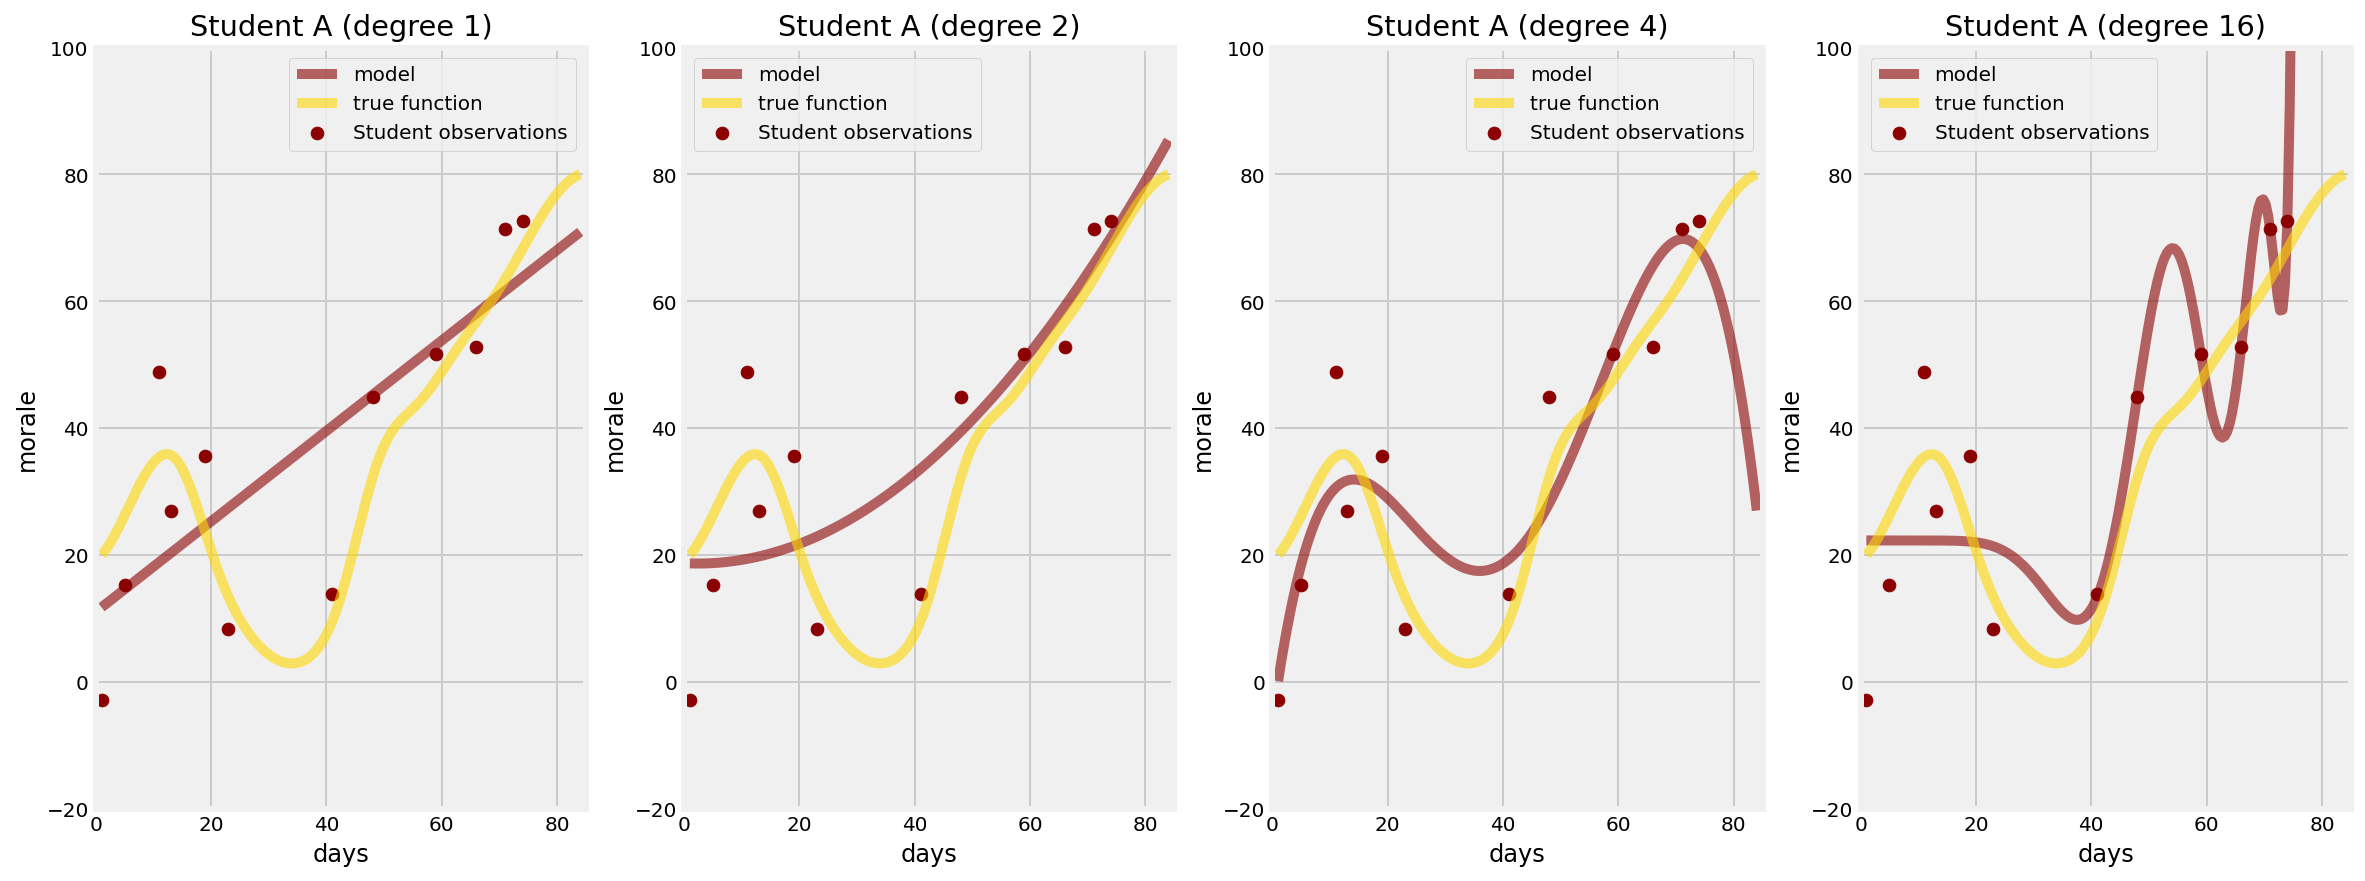

In [21]:
def plot_polyfit(X, y, truefunc, degrees=[1,2,4,16], 
                 student_color='darkred', name='A'):
    
    # set the plot size
    plt.subplots(figsize=(18,7))

    # create a plot for each polynomial degree plotted
    for i in range(len(degrees)):
        ax = plt.subplot(1, len(degrees), i + 1)
  
        poly_model = polynomial_modeler(X, y, degrees[i])

        X_test = np.linspace(1, 84, 200)
        plt.plot(X_test, poly_model.predict(X_test[:, np.newaxis]), lw=5.,
                 c=student_color, label="model", alpha=0.6)
        plt.plot(X_test, truefunc(X_test), lw=5., c='gold', alpha=0.6, label='true function')
        plt.scatter(X, y, label="Student observations", c=student_color, s=40)
        plt.xlabel("days")
        plt.ylabel("morale")
        plt.xlim((0, 85))
        plt.ylim((-20, 100))
        plt.legend(loc="best")
        
        plt.title('Student '+name+" (degree {})".format(degrees[i]))
        
plot_polyfit(students['A']['X_sampled'], students['A']['Y_sampled'], f_true,
             student_color='darkred', name='A')

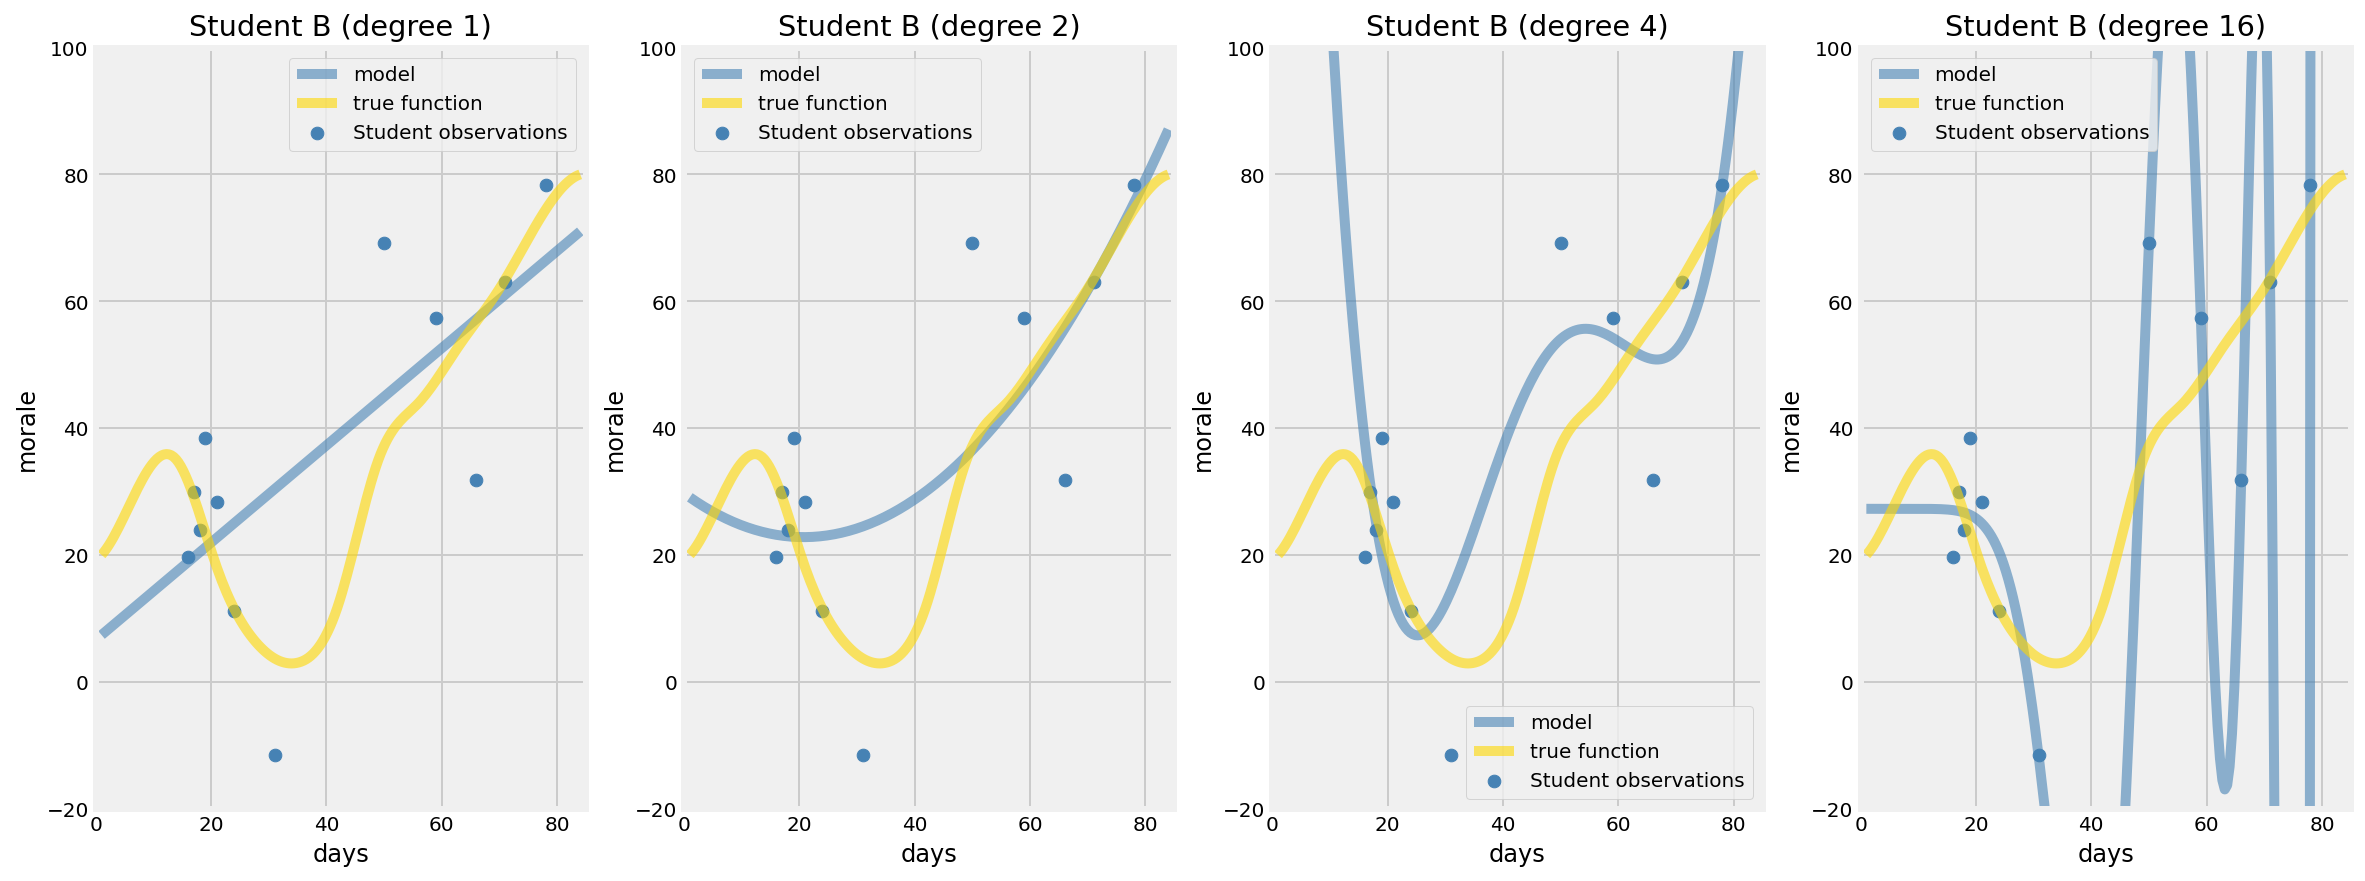

In [22]:
plot_polyfit(students['B']['X_sampled'], students['B']['Y_sampled'], f_true,
             student_color='steelblue', name='B')

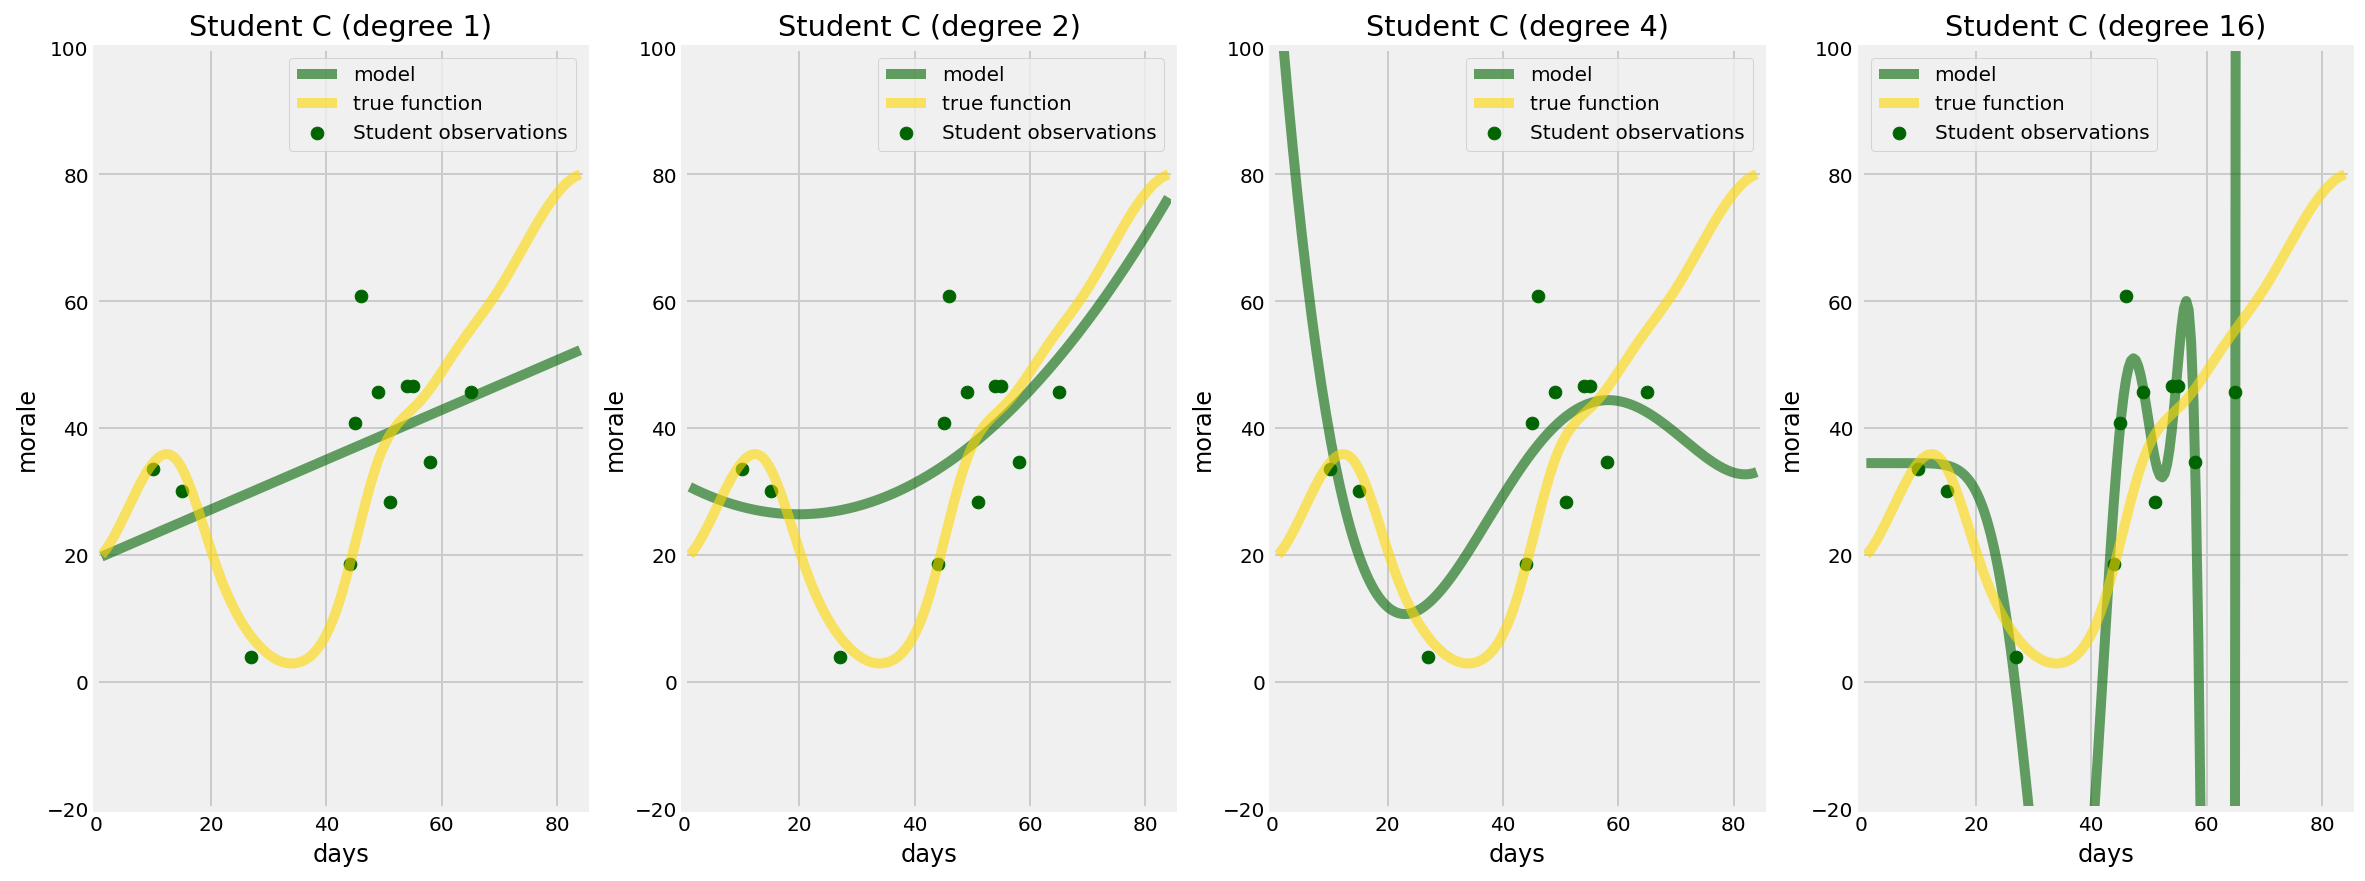

In [23]:
plot_polyfit(students['C']['X_sampled'], students['C']['Y_sampled'], f_true,
             student_color='darkgreen', name='C')

<a id='complexity-variance'></a>
## Higher complexity means higher variance (and lower bias)

---

The variance of predictions across our models goes up as we increase the model complexity. This is equivalent to saying that the variance of our model is increasing.

Increasing the complexity of the model at the expense of good future predictions is known as "overfitting" the data. High variance and overfitting are intrinsically related: if your predictions are inconsistent across samples, you are more likely to make the wrong predictions on future data.

Likewise, high bias and underfitting are related. If your model is too basic, it may give very consistent predictions but at the cost of oversimplifying the relationship between the target and predictors.

**Below are student A and student B fit with the 16-polynomial time model and the area showing the difference in predictions at time points between them.** Compare this to the area we saw earlier with the single time term.

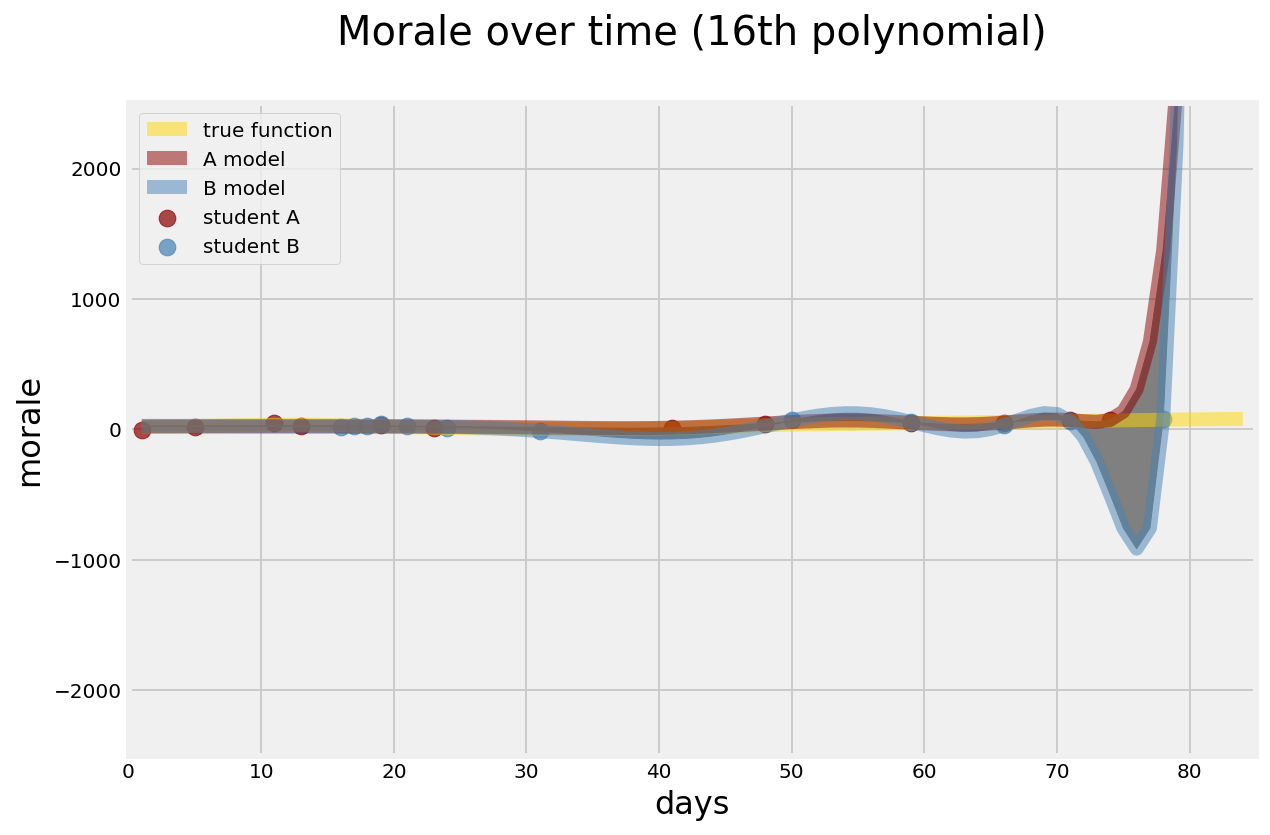

In [24]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(X_true,Y_true, lw=7., c='gold', alpha=0.5, label='true function')

Amod_complex = polynomial_modeler(students['A']['X_sampled'], students['A']['Y_sampled'], 16)
Bmod_complex = polynomial_modeler(students['B']['X_sampled'], students['B']['Y_sampled'], 16)


Apred = Amod_complex.predict(X_true[:, np.newaxis])
ax.plot(X_true, Apred, lw=7., c='darkred', alpha=0.5, label='A model')

Bpred = Bmod_complex.predict(X_true[:, np.newaxis])
ax.plot(X_true, Bpred, lw=7., c='steelblue', alpha=0.5, label='B model')

ax.scatter(students['A']['X_sampled'], students['A']['Y_sampled'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.scatter(students['B']['X_sampled'], students['B']['Y_sampled'],
           s=70, c='steelblue', label='student B', alpha=0.7)

ax.fill_between(X_true, Apred, Bpred, color='grey', hatch='//', edgecolor=None)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time (16th polynomial)\n', fontsize=20)
ax.set_xlim([0, 85])
ax.set_ylim([-2500,2500])

plt.legend(loc='upper left')

plt.show()